In [27]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt

In [6]:
# read df
dengue_df = pd.read_csv('../assets/sg_dengue_w_weather_df.csv')
dengue_df.head(1)

,Year,eWeek,Cases,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Year_eWeek,Date,Month,Year_Month
0,2014,1,437.0,3.255745,30.6,42.2,52.0,26.932,32.4,26.1,8.77125,72.4,2014-1,2014-01-06,1,2014-1


In [7]:
# Since these are time series datasets, we need the indices to be the Date columns
dengue_df.set_index(dengue_df['Date'], inplace = True)
dengue_df.drop(columns='Date',inplace = True)
dengue_df.head(1)

,Year,eWeek,Cases,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Year_eWeek,Month,Year_Month
Date,,,,,,,,,,,,,,,
2014-01-06,2014,1,437.0,3.255745,30.6,42.2,52.0,26.932,32.4,26.1,8.77125,72.4,2014-1,1,2014-1


In [8]:
# rename columns
dengue_df = dengue_df.rename(columns={"Daily Rainfall Total (mm)": "Avg Weekly Rainfall (mm)", 
                                      "Mean Temperature (°C)": "Avg Weekly Temperature",
                                      "Mean Wind Speed (km/h)": "Avg Weekly Wind Speed"})

In [9]:
# only look at relevant columns
relevant_columns = ['Cases', 'Avg Weekly Rainfall (mm)', 'Avg Weekly Temperature', 'Avg Weekly Wind Speed']
df = dengue_df[relevant_columns]
df.head(1)

,Cases,Avg Weekly Rainfall (mm),Avg Weekly Temperature,Avg Weekly Wind Speed
Date,,,,
2014-01-06,437.0,3.255745,26.932,8.77125


In [12]:
features = [col for col in df.columns if not col == 'Cases']
X = df[features]
y = df[['Cases']].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.head(1)

,Avg Weekly Rainfall (mm),Avg Weekly Temperature,Avg Weekly Wind Speed
Date,,,
2014-01-06,3.255745,26.932,8.77125


In [14]:
# scale data for any model that uses gradient descent, which includes neural networks.
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
# check if there's a need to reshape
# Assuming 'scaled_features' is your scaled data and 'n_features' is the number of features
# X_reshaped = scaled_features.reshape((scaled_features.shape[0], timesteps, n_features))

In [16]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [29]:
batch_x, batch_y = train_sequences[0]

In [30]:
batch_x.shape

(64, 3, 3)

In [31]:
batch_y.shape

(64, 1)

In [32]:
batch_x[0]

array([[-0.62887681, -1.39104714,  0.18273876],
       [ 0.58896111, -2.11183063, -0.74524552],
       [-1.32606285, -2.13035858,  2.2522045 ]])

In [33]:
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

,Avg Weekly Rainfall (mm),Avg Weekly Temperature,Avg Weekly Wind Speed
0,-0.628877,-1.391047,0.182739
1,0.588961,-2.111831,-0.745246
2,-1.326063,-2.130359,2.252204


In [17]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [21]:
input_shape = train_sequences[0][0][0].shape

In [25]:
# Initialize the RNN model
model = Sequential()

# Adding the input layer and the RNN layer
# 'input_shape' should match the shape of your input data
model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model.add(Dense(4, activation='relu'))

# Adding the output layer (linear activation for regression)
model.add(Dense(1, activation='linear'))

# Compile with mean squared error loss and mean absolute error metric
model.compile(optimizer=Adam(learning_rate=.0005), loss='mse', metrics=['mae'])

# Fitting the RNN to the Training set
history = model.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

C:\Users\idea\Anaconda3\envs\dsi-sg\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


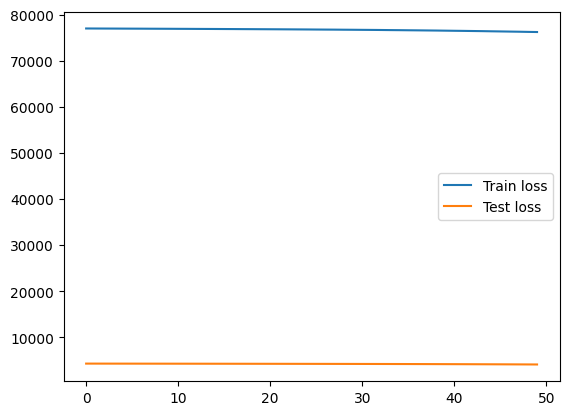

In [28]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend()

In [ ]:
# Add early stopping
es = EarlyStopping(patience=5)

# Create the second model with early stopping
model2 = Sequential()
model2.add(GRU(8, input_shape=(3, 8), return_sequences=True))
model2.add(GRU(8, return_sequences=False))

model2.add(Dense(4, activation='relu'))

# Change to linear activation for regression
model2.add(Dense(1, activation='linear'))

# Compile with mean squared error loss and mean absolute error metric
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model with early stopping
history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=100, batch_size=64, callbacks=[es])

In [ ]:
# Plot the loss for both models
plt.plot(history2.history['loss'], label='Train loss with ES')
plt.plot(history2.history['val_loss'], label='Test loss with ES')
plt.plot(history.history['loss'], label='Original Train loss')
plt.plot(history.history['val_loss'], label='Original Test loss')
plt.legend()